# Career Final Report

### Problem statement

**Repository with related notebooks**

[GitLab](https://gitlab.com/ricardoleoncorreia/buenos-aires-house-price-predictor).

**Dataset**

All the details about the houses can be downloaded from this ([link](https://drive.google.com/a/acamica.com/uc?export=download&id=1Ugbsw5XbNRbglomSQO1qkAgMFB_3BzmB)).

**Goal**

Study the feasibility of improving and expanding the coverage area of ​​the predictions by including additional methods to the analysis.

**Methods to implement**

* Data imputation.
* Include other types of properties.
* Use `XGBoost` model.

**Questions to answer**

* Is it possible to improve the performance of the model by imputing missing values?
* Is it possible to include other types of properties without impairing their performance?
* Will applying a model based on `Boosting` like` XGBosst` perform better in this problem?

**Expected results**

* By imputing data, an improvement in the performance of the model is expected.
* Including other types of properties will expand the coverage of the model's predictions without affecting its performance.

**Starting point**

This analysis will be based on the results found in the first two projects that covered the same problem:

* __Best model:__ Random Forest.
* __Metric:__ RMSE.
* __Used features:__

    * Latitude (lat).
    * Longitude (lon).
    * Rooms (rooms).
    * Bedrooms (bedrooms).
    * Bathrooms (bathrooms > 0).
    * Surface Total (surface_total <= 1000).
    * Surface Covered (surface_covered >= 18).
    * Property type (property_type).
    * Price (price >= 39000).
    * Neighborhood (l3).
    * Region (l2 = Capital Federal).

* __Used techniques:__

    * Validate data consistency (e.g. surface_total >= surface_covered).
    * Removing outliers: 3 sigma criterion.
    * PCA maintaining 95% variance in the data.


### Data preparation

To start the analysis for this notebook, all the necessary techniques will be applied to clean the dataset and have valid records.

The libraries are imported and the necessary constants and functions are defined below:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from time import time

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

In [2]:
random_state = 2021-3-6
test_size = 0.1
n_iter = 20
n_processors = -1

In [3]:
def count_removed_rows(initial, final):
    print(f"{initial - final} rows were removed")

def detect_outliers_3_sigma(data, criteria='3sigma'):
    data_description = data.describe()
    data_mean = data_description.loc['mean']
    data_std = data_description.loc['std']
    criteria_max = data_mean + 3 * data_std
    criteria_min = data_mean - 3 * data_std
    return (data < criteria_min) | (data > criteria_max)

def study_model(model, data, scoring="neg_root_mean_squared_error"):
    start = time()

    X_train, y_train = data
    model.fit(X_train, y_train)

    end = time()
    time_elapsed = end - start
    is_time_min = time_elapsed > 60
    if is_time_min:
        time_elapsed = time_elapsed / 60
    print(f"Time elapsed: {time_elapsed:0.4f} {'min' if is_time_min else 'sg'}")

def hyperparameter_optimization(model, params, data, strategy='random', n_iter=10, random_state=random_state, cv=5, scoring='neg_root_mean_squared_error'):
    search = RandomizedSearchCV(model, param_distributions=params, cv=cv, scoring=scoring, n_jobs=n_processors, n_iter=n_iter, random_state=random_state)
    study_model(search, data, scoring=scoring)
    print(f"Iterations: {n_iter}")
    print(f"Search strategy: {strategy}")
    print(f"Best params: {search.best_params_}")
    print(f"Best score ({cv}-fold CV): {-search.best_score_:0.2f} USD")
    return search

def plot_residuals(y, residuals, labels, legend=True):
    plt.figure(figsize=(15,5))
    sns.scatterplot(x=y/1000, y=residuals/1000, hue=labels, legend=legend)
    plt.xlabel('Price (kUSD)')
    plt.ylabel('Residual (kUSD)')
    plt.title('Residuals vs Prices')
    plt.show()
    
def count_missing_values(dataset, figsize=None):
    missing_values_count = pd.DataFrame(dataset.isna().sum(), columns=['count_'])
    missing_values_count['percentage'] = np.round(100 * missing_values_count.count_ / dataset.shape[0], 2)

    if figsize is not None:
        plt.figure(figsize=figsize)
        plt.xticks(rotation = 90)

    g = sns.barplot(x="index", y="count_", data=missing_values_count.reset_index())
    g.set_xlabel("Features")
    g.set_ylabel("Count")
    g.set_title("Missing values")
    
    if figsize is None:
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
    
    plt.show()

Import data:

In [4]:
dataset = pd.read_csv('properati.csv')
dataset.head()

start_date    end_date  created_on        lat        lon         l1  \
0  2019-10-17  2019-12-23  2019-10-17 -34.605880 -58.384949  Argentina   
1  2019-10-17  2019-11-21  2019-10-17 -34.624056 -58.412110  Argentina   
2  2019-10-17  2019-11-01  2019-10-17 -34.593569 -58.427474  Argentina   
3  2019-10-17  2019-12-23  2019-10-17 -34.581294 -58.436754  Argentina   
4  2019-10-17  2020-03-11  2019-10-17 -34.914194 -57.938219  Argentina   

                       l2             l3  rooms  bedrooms  bathrooms  \
0         Capital Federal  San Cristobal    7.0       7.0        2.0   
1         Capital Federal          Boedo    2.0       1.0        2.0   
2         Capital Federal        Palermo    2.0       1.0        1.0   
3         Capital Federal        Palermo    2.0       1.0        1.0   
4  Bs.As. G.B.A. Zona Sur       La Plata    2.0       1.0        1.0   

   surface_total  surface_covered     price currency  \
0          140.0            140.0  153000.0      USD   
1           70.0             58.0  159000.0      USD   
2           45.0             45.0  125000.0      USD   
3           85.0             50.0  295000.0      USD   
4           50.0             35.0   40000.0      USD   

                                               title  \
0        ***Venta semipiso centro, ideal hostel*****   
1   Espectacular PH reciclado en Boedo sin expensas.   
2  Depto.tipo casa de 2 ambientes en Venta en Pal...   
3  COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...   
4  58 entre 1 y 2  Venta de departamento en ph.1 ...   

                                         description property_type  \
0  DESCRIPCION DE LA PROPIEDAD: Departamento de 1...  Departamento   
1   PH reciclado en Boedo a una cuadra de la plaz...            PH   
2  2 ambienets amplio , excelente estado , patio ...            PH   
3  HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...            PH   
4  58 entre 1 y 2  Venta de departamento en PH. P...            PH   

  operation_type  
0          Venta  
1          Venta  
2          Venta  
3          Venta  
4          Venta

Only the mentioned features are preserved and the corresponding filters are applied:

In [5]:
initial_shape = dataset.shape[0]

dataset = dataset[['lat', 'lon', 'l2', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'property_type', 'price']]
dataset = dataset[dataset.l2 == "Capital Federal"]
dataset.drop(axis=1, columns=["l2"], inplace=True)

count_removed_rows(initial=initial_shape, final=dataset.shape[0])

54121 rows were removed


Invalid records are removed:

In [6]:
initial_shape = dataset.shape[0]

valid_registry_criteria = 'rooms >= bedrooms & surface_total >= surface_covered & surface_covered >= 18 & surface_total <= 1000 & bathrooms > 0 & price >= 39000'
dataset.query(valid_registry_criteria, inplace=True)

count_removed_rows(initial=initial_shape, final=dataset.shape[0])

12056 rows were removed


Outliers will be removed using the 3 sigma criterion:

In [7]:
initial_shape = dataset.shape[0]

# Removing outliers
numeric_columns = ['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']
for column in numeric_columns:
    columns_to_keep = ~detect_outliers_3_sigma(dataset[column])
    dataset = dataset[columns_to_keep].copy()
    
count_removed_rows(initial=initial_shape, final=dataset.shape[0])
print(f"Final shape => {dataset.shape}")

8856 rows were removed
Final shape => (71627, 10)


In order to measure whether the techniques to be used are effective and capable of answering the questions posed, a procedure must be established to follow. For each of them, the following steps will be performed:

1. A `LabelEncoder` and` OneHotEncoder` will be applied on the property type.
1. There will be a train/test split where the test size will be 10%.
1. The data will be scaled.
1. New variables will be generated by using PCA maintaining at least 95% of the variance of the data.
1. A `RandomForest` model will be trained, optimizing its hyperparameters using` RandomizedSearchCV` with CV = 5 and 20 iterations.
1. The RMSE of the model will be evaluated in the test set.
1. A scatter plot of the residuals by property type will be displayed in order to find possible patterns in the predictions.

The mentioned metric is the one that will serve to compare the effectiveness of the additional methods to be applied in the present analysis.

The following function translates the previously explained steps into code:

In [8]:
def perform_analysis(tidy_dataset, test_size, random_state, n_iter, model, hyperparams, n_processors):
    # LabelEncoder & OneHotEncoder.
    property_type_label_encoder = LabelEncoder()
    tidy_dataset['property_type_encoded'] = property_type_label_encoder.fit_transform(tidy_dataset.property_type)

    property_type_one_hot_encoder = OneHotEncoder(sparse=False)
    property_type_encoded = property_type_one_hot_encoder.fit_transform(tidy_dataset.property_type_encoded.to_numpy().reshape(-1, 1))
    tidy_dataset = pd.concat([tidy_dataset.reset_index(drop=True), pd.DataFrame(property_type_encoded, columns=property_type_label_encoder.classes_)], axis=1)
    tidy_dataset.drop(['property_type_encoded'], axis=1, inplace=True)
    tidy_dataset.head()

    # Train/Test split
    label_columns = ['l3', 'property_type']
    X = tidy_dataset.drop(['price'], axis=1)
    y = tidy_dataset.price

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    X_train_labels = X_train[label_columns].copy()
    X_test_labels = X_test[label_columns].copy()

    X_train = X_train.drop(label_columns, axis=1).copy()
    X_test = X_test.drop(label_columns, axis=1).copy()

    # Scaling.
    columns_to_scale = ['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
    ct = ColumnTransformer([('scaler', StandardScaler(), columns_to_scale)], remainder='passthrough')

    X_train = pd.DataFrame(ct.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(ct.transform(X_test), columns=X_test.columns)

    # PCA (95% variance).
    pca_total = PCA(n_components=X_train.shape[1], random_state=random_state)
    pca_total.fit(X_train)
    
    cummulative_explained_variance = np.cumsum(pca_total.explained_variance_ratio_)
    n_components = (cummulative_explained_variance < 0.95).sum() + 1
    print(f'Number of principal components {n_components} ({100 * cummulative_explained_variance[n_components-1]:.2f}%)')

    pca = PCA(n_components=n_components, random_state=random_state)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    # Model Training
    forest_search = hyperparameter_optimization(model=model, params=hyperparams, data=(X_train, y_train), n_iter=n_iter)

    # Model Evaluation
    y_test_pred = forest_search.predict(X_test)
    print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f} USD')
    
    # Plot Residuals
    residuals = y_test - y_test_pred
    plot_residuals(y=y_test, residuals=residuals, labels=X_test_labels.property_type)

### Benchmark

We will try to reproduce the analysis of the previous versions to have a point of comparison.
In this case, the dataset will be filtered as follows:

* Only properties of the type `House`,` Apartment` and `PH`.
* Remove rows with missing values.

In [9]:
initial_shape = dataset.shape[0]

benchmark_dataset = dataset[dataset.property_type.isin(["Casa", "Departamento", "PH"])].copy()
benchmark_dataset.dropna(inplace=True)

count_removed_rows(initial=initial_shape, final=benchmark_dataset.shape[0])

3654 rows were removed


Starting with the aforementioned analysis:

In [10]:
param_distributions = {
    'n_estimators': stats.randint(low=100,high=200),
    'max_depth': stats.randint(low=25,high=50),
    'max_features': ['auto', 'sqrt', 'log2']
}
forest = RandomForestRegressor(random_state=random_state, n_jobs=n_processors)
perform_analysis(model=forest, hyperparams=param_distributions, tidy_dataset=benchmark_dataset, test_size=test_size, random_state=random_state, n_iter=n_iter, n_processors=n_processors)

Number of principal components 5 (95.52%)
Time elapsed: 6.2948 min
Iterations: 20
Search strategy: random
Best params: {'max_depth': 25, 'max_features': 'sqrt', 'n_estimators': 152}
Best score (5-fold CV): 29921.32 USD
Test RMSE: 27507.26 USD


### Is it possible to improve the performance of the model by imputing missing values?

In the previous section, two filters were applied:

* Type of property: `House`,` Apartment` and `PH`.
* Discard rows with missing values.

In this case, only filtering by property will be applied:

In [11]:
initial_shape = dataset.shape[0]

dataset_impute_missing = dataset[dataset.property_type.isin(["Casa", "Departamento", "PH"])].reset_index(drop=True).copy()

count_removed_rows(initial=initial_shape, final=dataset_impute_missing.shape[0])

321 rows were removed


Here is a count of the missing values:

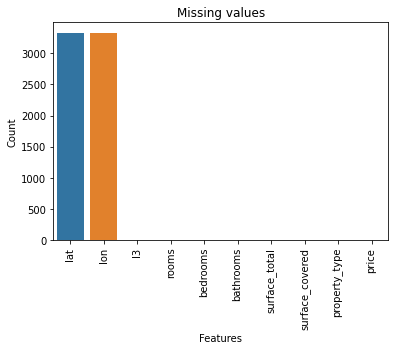

In [12]:
count_missing_values(dataset_impute_missing)

For the dataset in the state it is now, there are only missing values in the latitude and longitude columns.

There are several strategies to consider when trying to impute values, such as using the average, the median or a fixed value. However, considering the nature of the data these standard strategies would not make sense. For example we can take the average. Using the average to impute the data would mean that the almost 3,000 properties are located in the center of Buenos Aires (like a building in downtown). This would only generate more inconsistency in the data and would conflict with the value of column `l3` (neighborhood).

An approximation that could be taken is the average per neighborhood. Which would mean that the properties would be in the center of the respective neighborhoods. The latter would not create a conflict in the data.
The imputation of values will be done with both the average and the median.

A function will be built that will serve to perform the analysis for both cases:

In [13]:
lat_lon_statistic = dataset[['lat', 'lon', 'l3']].copy()
lat_lon_statistic.rename(columns={'lat': 'lat_statistic', 'lon': 'lon_statistic'}, inplace=True)

def lat_lon_imputation(dataset, lat_lon_statistic, random_state=random_state, n_processors=n_processors, test_size=test_size, n_iter=n_iter):
    # Get all statistics for each row
    dataset_regions = dataset[['l3']].copy()
    dataset_regions = pd.merge(left=dataset_regions, right=lat_lon_statistic, on='l3', how='left')
    
    # Impute latitude
    lat_missing_values = dataset.lat.isna()
    dataset.lat.fillna(dataset_regions.lat_statistic[lat_missing_values.values], inplace=True)
    
    # Impute longitude
    lon_missing_values = dataset.lon.isna()
    dataset.lon.fillna(dataset_regions.lon_statistic[lon_missing_values.values], inplace=True)
    
    print(f"Missing latitude values: {dataset.lat.isna().sum()}")
    print(f"Missing longitude values: {dataset.lon.isna().sum()}")
    
    # Train and evaluate model
    param_distributions = {
        'n_estimators': stats.randint(low=100,high=200),
        'max_depth': stats.randint(low=25,high=50),
        'max_features': ['auto', 'sqrt', 'log2']
    }
    forest = RandomForestRegressor(random_state=random_state, n_jobs=n_processors)
    perform_analysis(model=forest, hyperparams=param_distributions, tidy_dataset=dataset, test_size=test_size, random_state=random_state, n_iter=n_iter, n_processors=n_processors)

Imputating the average by neighborhood:

In [14]:
lat_lon_imputation(dataset=dataset_impute_missing.copy(), lat_lon_statistic=lat_lon_statistic.groupby('l3').mean().reset_index().copy())

Missing latitude values: 0
Missing longitude values: 0
Number of principal components 5 (95.58%)
Time elapsed: 6.8199 min
Iterations: 20
Search strategy: random
Best params: {'max_depth': 26, 'max_features': 'sqrt', 'n_estimators': 174}
Best score (5-fold CV): 30469.06 USD
Test RMSE: 29425.42 USD


Now, imputating the median value by neighborhood:

In [15]:
lat_lon_imputation(dataset=dataset_impute_missing.copy(), lat_lon_statistic=lat_lon_statistic.groupby('l3').median().reset_index().copy())

Missing latitude values: 0
Missing longitude values: 0
Number of principal components 5 (95.58%)
Time elapsed: 6.9939 min
Iterations: 20
Search strategy: random
Best params: {'max_depth': 46, 'max_features': 'log2', 'n_estimators': 195}
Best score (5-fold CV): 30545.92 USD
Test RMSE: 29479.92 USD


In both cases, an increase in error is evident, which indicates that the data imputation method does not help to improve the performance of the model.

### Is it possible to include other types of properties without impairing their performance?

For this case, only the rows with missing values will be deleted:

In [16]:
initial_shape = dataset.shape[0]

all_properties_dataset = dataset.copy()
all_properties_dataset.dropna(inplace=True)

count_removed_rows(initial=initial_shape, final=all_properties_dataset.shape[0])
other_properties_shape = all_properties_dataset[~all_properties_dataset.property_type.isin(["Casa", "Departamento", "PH"])].shape
print(f"Other properties shape: {other_properties_shape}")

3348 rows were removed
Other properties shape: (306, 10)


The number of records added to the dataset is relatively low (<1%). With the data prepared for the training, the process begins:

In [17]:
param_distributions = {
    'n_estimators': stats.randint(low=100,high=200),
    'max_depth': stats.randint(low=25,high=50),
    'max_features': ['auto', 'sqrt', 'log2']
}
forest = RandomForestRegressor(random_state=random_state, n_jobs=n_processors)
perform_analysis(model=forest, hyperparams=param_distributions, tidy_dataset=all_properties_dataset, test_size=test_size, random_state=random_state, n_iter=n_iter, n_processors=n_processors)

Number of principal components 5 (95.44%)
Time elapsed: 6.7595 min
Iterations: 20
Search strategy: random
Best params: {'max_depth': 26, 'max_features': 'sqrt', 'n_estimators': 174}
Best score (5-fold CV): 29891.38 USD
Test RMSE: 28575.67 USD


Despite the low number of records added (300 approx), the weight of the error is equivalent to that obtained in the previous question where many more records were included (3,000 approx). Comparing both residual plots, we see that in this case we have residuals that reaches USD 300,000 while in original, it is around USD 200,000. This suggests that there is no evident patterns that relate the property types `House`,` Apartment` and `PH`, so it may be convenient to make a separate model for the latter.

It can thus be concluded that including other properties does not add value to the performance of the model.

### Will applying a `Boosting` based model like` XGBoost` will perform better on this problem?

Bagging and boosting are two model assembly concepts that take advantage of different model states (overfitting vs underfitting) to achieve better overall performance. Two of the best known exponents in both concepts are Random Forest and XGBoost respectively. Both are based (with their exceptions) on the same model: Decision Tree.

Unlike Random Forest, XGBoost relies on taking advantage of various models with underfitting and gradient descent to adjust for errors. Since the Random Forest model gave good results on predictions, it would be worth trying this model and comparing results.

First, the dataset will be taken to the same point as the one used in the benchmark in order to make a correct comparison between models:

In [18]:
initial_shape = dataset.shape[0]

xgb_dataset = dataset[dataset.property_type.isin(["Casa", "Departamento", "PH"])].copy()
xgb_dataset.dropna(inplace=True)

count_removed_rows(initial=initial_shape, final=xgb_dataset.shape[0])

3654 rows were removed


Since XGBoost has an API compatible with Scikit Learn, you can take advantage of the classes and methods that the latter offers in its library.
The hyperparameters to optimize will be the following:

* `n_estimators:` number of decision trees to use in the model.
* `booster:` Two will be used, `gbtree` to use a decision tree assembly and [DART](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html).
* `learning_rate:` used in gradient descent operations (the default value `None` will be included in the options).

Starting the training process:

In [20]:
param_distributions = {
    'n_estimators': stats.randint(low=100,high=200),
    'booster': ['gbtree', 'dart'],
    'learning_rate': [0.05, 0.1, None],
}
xgb = XGBRegressor(objective='reg:squarederror', random_state=random_state, n_jobs=n_processors)
perform_analysis(model=xgb, hyperparams=param_distributions, tidy_dataset=xgb_dataset, test_size=test_size, random_state=random_state, n_iter=n_iter, n_processors=n_processors)

Number of principal components 5 (95.52%)
Time elapsed: 6.9557 min
Iterations: 20
Search strategy: random
Best params: {'booster': 'gbtree', 'learning_rate': None, 'n_estimators': 195}
Best score (5-fold CV): 35455.98 USD
Test RMSE: 34461.32 USD


It can be seen that the error of the `XGBoost` model is much greater than the benchmark, so we conclude that this model, for this particular problem, can be discarded.

### Results analysis

**Is it possible to improve the performance of the model by imputing missing values?**

Latitude and longitude are fields with particular properties. In real life situations, it is known that within the same neighborhood there may be different areas with different economic levels. This depends a lot on the neighborhood. Considering the above, it can be explained why the applied technique did not have the desired effect.

Making the imputation considering the average or median per neighborhood is equivalent to saying that all those properties (either `House`,` Apartment` or `PH`) are located on the same point (e.g. the same building) in downtown, which can be contradicted, in some cases, by what is stated in the previous paragraph. This could explain the deterioration in performance.

Other techniques such as `KNNImputer` could be considered, however this technique involves a number of calculations that may not compensate for the value of a possible improvement. Another strategy that could be considered is to impute the values not only considering the neighborhoods but also the prices, but doing this will generate a `memory leak` that will create an illusion of improvement in performance when in reality, the training data will have clues about the value real property.

With the data and strategies that are available at the moment, the answer to this question is no.

**Is it possible to include other types of properties without impairing their performance?**

The `OneHotEncoder` class is very useful when including new types of properties by implementing the appropriate code. However, despite being a relatively small number of rows that were included, the effect on performance is very large. Therefore, it can be thought that a separate model can help their inclusion.

A point to highlight is that, to ensure good performance and generalization of the results on the few data available, it is:

* Validate that they are a representative sample of the population of the properties other than `House`,` Apartment` or `PH`.
* Increase the amount of data (considering the previous point).

The answer to this question is: Possible, but a separate analysis must be performed for these properties.

**Will applying a `Boosting` based model like` XGBoost` perform better on this problem?**

For the problem raised, `XGBoost` performed worse than` Random Forest`, so the `XGBoost` model can be discarded. The answer to this question is no.

### Conclusions

* The original model remains the best option to take to production.
* The three procedures implemented in this analysis do not add value to the performance of the model obtained in previous notebooks.
* Although the answers to the three questions were negative, it was possible to apply 3 different strategies not implemented in the previous phases of the project.
* Possible points for improvement:

    * For the expansion of the coverage of property types, it may be considered to train a separate model.
    * Models based on neural networks can be used to find better performances on the problem, always taking into account the scalability of the model.
    * Possibly better performance can be obtained using NLP techniques on descriptions to find relevant features (e.g. if you have a pool, central heating, etc).